In [0]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.optim as optim
import numpy as np
from math import sqrt
import random

In [0]:
%matplotlib inline

In [0]:
torch.set_default_dtype(torch.float64)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [0]:
class GeneratorAllConv(nn.Module):
    def __init__(self, latent_vector_length=25, num_channels=128):
        super().__init__()
        self.latent_vector_length = latent_vector_length
        self.conv_tr1 = nn.ConvTranspose2d(in_channels=self.latent_vector_length, out_channels=num_channels, stride=1, kernel_size=4, padding=0) #(N, 25, 1, 1) -> (N, 64, 4, 4)
        self.conv_tr2 = nn.ConvTranspose2d(in_channels=num_channels, out_channels=num_channels//2, stride=2, kernel_size=5, padding=0) #(N, 64, 4, 4) -> (N, 32, 11, 11)
        self.conv_tr3 = nn.ConvTranspose2d(in_channels=num_channels//2, out_channels=num_channels//4, stride=2, kernel_size=5, padding=0) #(N, 32, 11, 11) -> (N, 16, 25, 25)
        self.conv_tr4 = nn.ConvTranspose2d(in_channels=num_channels//4, out_channels=1, stride=1, kernel_size=4, padding=0)  #(N, 16, 25, 25) -> (N, 1, 28, 28)
        
        self.conv_bn1 = nn.BatchNorm2d(num_channels)
        self.conv_bn2 = nn.BatchNorm2d(num_channels//2)
        self.conv_bn3 = nn.BatchNorm2d(num_channels//4)
    
    def forward(self, xb):
        x = F.relu(self.conv_tr1(xb))
        x = self.conv_bn1(x)
        
        x = F.relu(self.conv_tr2(x))
        x = self.conv_bn2(x)
        
        x = F.relu(self.conv_tr3(x))
        x = self.conv_bn3(x)
        
        x = F.relu(self.conv_tr4(x))
        return torch.tanh(x)
        

In [0]:
class GeneratorUpsampleConv(nn.Module):
    def __init__(self, latent_vector_length=100, num_channels=128):
        super().__init__()
        

In [0]:
class GeneratorFC(nn.Module):
    def __init__(self, latent_vector_length=25):
        super().__init__()
        self.latent_vector_length = latent_vector_length
        self.fc1 = nn.Linear(self.latent_vector_length, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, 28*28)
        
        self.leakyrelu = nn.LeakyReLU(negative_slope=0.2)
        
    def forward(self, xb):
        x = xb.view(-1, self.latent_vector_length)
        x = self.leakyrelu(self.fc1(x))
        x = self.leakyrelu(self.fc2(x))
        x = self.leakyrelu(self.fc3(x))
        return torch.tanh(self.fc4(x).view(-1, 1, 28, 28))
        

In [0]:
class DiscriminatorAllConv(nn.Module):
    def __init__(self, num_channels=256):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=num_channels//4, stride=2, kernel_size=4, padding=1)               #(N, 1, 28, 28) -> (N, 16, 14, 14)
        self.conv2 = nn.Conv2d(in_channels=num_channels//4, out_channels=num_channels//2, stride=2, kernel_size=4, padding=1)  #(N, 16, 14, 14) -> (N, 32, 7, 7)
        self.conv3 = nn.Conv2d(in_channels=num_channels//2, out_channels=num_channels, stride=1, kernel_size=4, padding=0)    #(N, 32, 7, 7) -> (N, 64, 4, 4)
        self.conv4 = nn.Conv2d(in_channels=num_channels, out_channels=1, stride=1, kernel_size=4, padding=0)                 #(N, 64, 4, 4) -> (N, 1, 1, 1)
        
        self.conv_bn1 = nn.BatchNorm2d(num_channels//4)
        self.conv_bn2 = nn.BatchNorm2d(num_channels//2)
        self.conv_bn3 = nn.BatchNorm2d(num_channels)
        
        self.leakyrelu = nn.LeakyReLU(negative_slope=0.1)
        
    def forward(self, xb):
        x = self.leakyrelu(self.conv1(xb))
        x = self.conv_bn1(x)
    
        x = self.leakyrelu(self.conv2(x))
        x = self.conv_bn2(x)
        
        x = self.leakyrelu(self.conv3(x))
        x = self.conv_bn3(x)
        
        return torch.sigmoid(self.conv4(x))

In [0]:
class DiscriminatorFC(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 1)
        
        self.leakyrelu = nn.LeakyReLU(negative_slope=0.2)
        
    def forward(self, xb):
        x = xb.view(-1, 28*28)
        x = self.leakyrelu(self.fc1(x))
        x = F.dropout(x, training=self.training, p=0.5)
        x = self.leakyrelu(self.fc2(x))
        x = F.dropout(x, training=self.training, p=0.5)
        x = self.leakyrelu(self.fc3(x))
        x = F.dropout(x, training=self.training, p=0.5)
        return torch.sigmoid(self.fc4(x)).view(-1, 1)

In [0]:
from torchvision import datasets
import torchvision.transforms as transforms

dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=128,
    shuffle=True,
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 19063600.02it/s]                            


Extracting ../../data/mnist/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 322020.41it/s]                           
0it [00:00, ?it/s]

Extracting ../../data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 5280772.49it/s]                           
8192it [00:00, 128954.28it/s]


Extracting ../../data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ../../data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
def train_discriminator(optimizer, real_images, fake_images, D):
    optimizer.zero_grad()
    
    D.train()
    
    loss = nn.BCELoss()
    
#     print("shape: {}".format(real_images.shape))
    real_preds = D(real_images).view(-1, 1)
    real_loss = loss(real_preds, 0.9 * torch.ones(real_images.shape[0], 1).to(device))
    real_loss.backward()
    
    fakes_preds = D(fake_images).view(-1, 1)
    fakes_loss = loss(fakes_preds, torch.zeros(fake_images.shape[0], 1).to(device))
    fakes_loss.backward()
    
    optimizer.step()
    
    return real_loss, real_preds, fakes_loss, fakes_preds
    
    
def train_generator(optimizer, fake_images, D):
    optimizer.zero_grad()
    
    loss = nn.BCELoss()
    
    D.eval()
    
    fakes_preds = D(fake_images).view(-1, 1)
    
    g_loss = loss(fakes_preds, torch.ones(fake_images.shape[0], 1).to(device))
    
    g_loss.backward()
    
    optimizer.step()
    
    return g_loss

In [0]:
def plot_losses(G_losses, D_total_losses, D_real_losses, D_fakes_losses):
    plt.rcParams["figure.figsize"] = [15, 10]

    arr_title_list = [
        (G_losses, "Generator loss"), 
        (D_total_losses, "Discriminator total loss"), 
        (D_real_losses, "Discriminator loss on reals"), 
        (D_fakes_losses, "Discriminator loss on fakes")
    ]
    
    i = 1
    for losses, title in arr_title_list:
        plt.subplot(2, 2, i)
        plt.plot(losses)
        plt.title(title)
        plt.xlabel("batches")
        plt.ylabel("loss")
        i += 1

In [0]:
def plot_generated_images(images, num_per_row=1, skip_by=1):
    x = num_per_row
    y = len(images) // skip_by + 1
    print(x, y)
    
    fig = plt.figure(figsize=(x, y))
    plt.rcParams["figure.figsize"] = [2*x, 1.5*y]

    for i in range(0, len(images), skip_by):
        ims = images[i]
    
        for j in range(x):
            ax1 = plt.subplot(y, x, (i*x)/skip_by+j+1)
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
            plt.imshow(ims[j].squeeze(0), cmap="gray")
            min_val = ims[j].squeeze(0).min(0).values.min(0).values.item()
            max_val = ims[j].squeeze(0).max(0).values.max(0).values.item()
#             plt.title("min:{0:.2f}\nmax:{1:.2f}".format(min_val, max_val))
    

#     fig.subplots_adjust(wspace=0, hspace=0)
    plt.show()

In [0]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
#     torch.backends.cudnn.benchmark = False
#     torch.backends.cudnn.deterministic = True

In [0]:
def train_alternate_MNIST(epochs, DS, GS, optimizer_D, optimizer_G):
    D_real_losses = []
    D_fakes_losses = []
    D_total_losses = []
    G_losses = []
    images = []
    
    l = GS.latent_vector_length
    
    for epoch in range(epochs):
        print("Epoch #{}".format(epoch))
        for i, (imgs, _) in enumerate(dataloader):
            real_batch = torch.tensor(imgs.clone().detach(), dtype=torch.float64).to(device)
            random_vector = torch.randn(64, l, 1, 1).to(device)
            
            GS.eval()#to disable dropout
            fakes_batch_detached = GS(random_vector).to(device).detach()
            GS.train()
            
            D_loss_real, D_preds_real, D_loss_fake, D_preds_fake = train_discriminator(optimizer_D, real_batch, fakes_batch_detached, DS)
            
            D_real_losses.append(D_loss_real.cpu())
            D_fakes_losses.append(D_loss_fake.cpu())
            D_total_losses.append(D_loss_real.cpu() + D_loss_fake.cpu())
            
            fakes_batch = GS(random_vector).to(device)
            G_loss = train_generator(optimizer_G, fakes_batch, DS)
            
            G_losses.append(G_loss.cpu())
            
            if i % 50 == 0:
                print("iteration#{} done".format(i))
                images.append(fakes_batch.detach().cpu())
    return (D_real_losses,
        D_fakes_losses,
        D_total_losses,
        G_losses,
        images
    )

In [0]:

def experiment_MNIST(D_optimizer="SGD", D_lr=0.005, D_momentum=0.9, G_optimizer="Adam", G_lr=0.005, G_momentum=0.9, epochs=1, D=None, G=None, train_policy_function=train_alternate_MNIST, D_class=DiscriminatorFC, G_class=GeneratorFC):
    DS = D_class().to(device)
    if D is not None:
        DS.load_state_dict(D.state_dict())
        
    GS = G_class(latent_vector_length=100).to(device)
    if G is not None:
        GS.load_state_dict(G.state_dict())

    if D_optimizer == "SGD":
        optimizer_D = optim.SGD(DS.parameters(), lr=D_lr, momentum=D_momentum)
    elif D_optimizer == "Adam":
        optimizer_D = optim.Adam(DS.parameters(), lr=D_lr, betas=[0.5, 0.999])
    
    if G_optimizer == "SGD":
        optimizer_G = optim.SGD(GS.parameters(), lr=G_lr, momentum=G_momentum)
    elif G_optimizer == "Adam":
        optimizer_G = optim.Adam(GS.parameters(), lr=G_lr, betas=[0.5, 0.999])
    
    

    D_real_losses, D_fakes_losses, D_total_losses, G_losses, images = train_policy_function(epochs, DS=DS, GS=GS, optimizer_D=optimizer_D, optimizer_G=optimizer_G)
    
    plot_losses(G_losses, D_total_losses, D_real_losses, D_fakes_losses)
    
    return (images, GS, DS)

In [0]:
def train_alternate_MNIST_principled(epochs, DS, GS, optimizer_D, optimizer_G, D_thres=0.1, G_thres=0.1):
    D_real_losses = []
    D_fakes_losses = []
    D_total_losses = []
    G_losses = []
    images = []
    
    l = GS.latent_vector_length
    
    d_lossmovingaverage = 0.0
    g_lossmovingaverage = 0.0
    
    g_train_count = 0
    
    for epoch in range(epochs):
        print("Epoch #{}".format(epoch))
        for i, (imgs, _) in enumerate(dataloader):
            random_vector = torch.randn(64, l, 1, 1).to(device)
            
            #TODO: refactor; put each in a separate function to reduce repetition
            
            trained_any = False
            fakes_batch = None
            
            if d_lossmovingaverage >= D_thres and d_lossmovingaverage > g_lossmovingaverage:
                #train D
                real_batch = torch.tensor(imgs.clone().detach(), dtype=torch.float64).to(device)
                fakes_batch_detached = GS(random_vector).to(device).detach()
            
                D_loss_real, D_preds_real, D_loss_fake, D_preds_fake = train_discriminator(optimizer_D, real_batch, fakes_batch_detached, DS)
            
                D_real_losses.append(D_loss_real.cpu())
                D_fakes_losses.append(D_loss_fake.cpu())
                D_total_losses.append(D_loss_real.cpu() + D_loss_fake.cpu())
                
                d_lossmovingaverage += (D_loss_real + D_loss_fake).sum()
                d_lossmovingaverage /= 2.0
                
                trained_any = True
            if g_lossmovingaverage >= G_thres and d_lossmovingaverage < g_lossmovingaverage:
                #train G
                fakes_batch = GS(random_vector).to(device)
                G_loss = train_generator(optimizer_G, fakes_batch, DS)
            
                G_losses.append(G_loss.cpu())
                
                g_lossmovingaverage += G_loss.sum()
                g_lossmovingaverage /= 2.0
                
                g_train_count += 1
                
                if g_train_count % 10 == 0:
                    images.append(fakes_batch.detach().cpu())
                
                trained_any = True
            
            if i % 50 == 0:
                print("iteration#{} done".format(i))
    return (D_real_losses,
        D_fakes_losses,
        D_total_losses,
        G_losses,
        images
    )

In [0]:
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.index = 0
        
    def __len__(self):
        return len(self.memory)
    
    def push(self, val):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        
        self.memory[self.index] = val
        self.index = (self.index + 1) % self.capacity
    
    def sample(self, n):
        assert n <= len(self.memory)
        
        return random.sample(self.memory, n)
    
    def sample_tensor(self, n):
        return torch.cat(self.sample(n)).view(n, -1, 1, 1)

In [0]:
def train_alternate_MNIST_principled_replay(epochs, DS, GS, optimizer_D, optimizer_G, D_thres=0.1, G_thres=0.1, memory_capacity=200, init_memory=False):
    D_real_losses = []
    D_fakes_losses = []
    D_total_losses = []
    G_losses = []
    images = []
    
    memory = ReplayMemory(memory_capacity)
    
    l = GS.latent_vector_length
    
    if init_memory:
        for i in range(memory_capacity):
            memory.push(torch.randn(l))
    
    d_lossmovingaverage = 5.0
    g_lossmovingaverage = 5.0 #so that it starts training
    
    g_train_count = 0
    d_train_count = 0
    
    for epoch in range(epochs):
        print("Epoch #{}".format(epoch))
        for i, (imgs, _) in enumerate(dataloader):
            memory.push(torch.randn(l))
            
            #TODO: refactor; put each in a separate function to reduce repetition
            
            train_d_only = False
            random_vector = None
            fakes_batch = None
            
            if len(memory) < dataloader.batch_size:
                train_d_only = True
                random_vector = torch.randn(dataloader.batch_size, l, 1, 1).to(device)
            else:
                random_vector =  memory.sample_tensor(dataloader.batch_size).to(device)
#                 print(random_vector.shape)
            
            if train_d_only or d_lossmovingaverage >= g_lossmovingaverage:
                #train D
                real_batch = torch.tensor(imgs.clone().detach(), dtype=torch.float64).to(device)
                fakes_batch_detached = GS(random_vector).to(device).detach()
            
                D_loss_real, D_preds_real, D_loss_fake, D_preds_fake = train_discriminator(optimizer_D, real_batch, fakes_batch_detached, DS)
            
                D_real_losses.append(D_loss_real.cpu())
                D_fakes_losses.append(D_loss_fake.cpu())
                D_total_losses.append(D_loss_real.cpu() + D_loss_fake.cpu())
                
                d_lossmovingaverage += (D_loss_real + D_loss_fake).sum()
                d_lossmovingaverage /= 2.0
                
                d_train_count += 1
#                 print("D training #{}".format(d_train_count))
                
            if (not train_d_only) and d_lossmovingaverage <= g_lossmovingaverage:
                #train G
                fakes_batch = GS(random_vector).to(device)
                G_loss = train_generator(optimizer_G, fakes_batch, DS)
            
                G_losses.append(G_loss.cpu())
                
                g_lossmovingaverage += G_loss.sum()
                g_lossmovingaverage /= 2.0
                
                g_train_count += 1
                
#                 print("G training #{}".format(g_train_count))
                
                if g_train_count % 10 == 0:
#                     print("g train count crossed another 10")
                    images.append(fakes_batch.detach().cpu())
            
            if i % 50 == 0:
                print("minibatch #{} done".format(i))
                
    return (D_real_losses,
        D_fakes_losses,
        D_total_losses,
        G_losses,
        images
    )

All that fancy transpose convstuff doesn't seem to be working. Let's just try simple feedforward fully connected now

Generator is FC and Discriminator is Convolutional

In [0]:
(imgs1, GR1, DR1) = experiment_MNIST(D_optimizer="SGD", D_lr=0.002, D_momentum=0.5, G_optimizer="SGD", G_lr=0.002, G_momentum=0.5, epochs=2, D=None, G=None, train_policy_function=train_alternate_MNIST, D_class=DiscriminatorAllConv, G_class=GeneratorFC)

In [0]:
plot_generated_images(imgs1, num_per_row=3)

In [0]:
(imgs1, GR1, DR1) = experiment_MNIST(D_optimizer="SGD", D_lr=0.002, D_momentum=0.5, G_optimizer="SGD", G_lr=0.002, G_momentum=0.5, epochs=7, D=None, G=None, train_policy_function=train_alternate_MNIST, D_class=DiscriminatorFC, G_class=GeneratorFC)

In [0]:
plot_generated_images(imgs1, num_per_row=3)

-0.22035149570388812 0.230224271437809


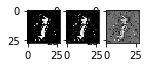

In [0]:
a = torch.randn((100, GR1.latent_vector_length, 1, 1)).to(device)
generated = None
with torch.no_grad():
    generated = GR1(a)
#     plot_generated_images(generated.cpu())

im1 = generated[0].view(28, 28).cpu()
im2 = generated[1].view(28, 28).cpu()
im3 = im1 - im2
# im3.numpy()

plt.subplot(1, 3, 1)
plt.imshow(im1.numpy(), cmap="gray")
plt.subplot(1, 3, 2)
plt.imshow(im2.numpy(), cmap="gray")
plt.subplot(1, 3, 3)
plt.imshow(im3.numpy(), cmap="gray")

min_val = im3.min(1).values.min(0).values.item()
max_val = im3.max(1).values.max(0).values.item()
print(min_val, max_val)

Was I training the non-conditional version all along when I thought the oscillation was due to the conditional training?

Both D and G are FC

In [0]:
(imgs2, GR2, DR2) = experiment_MNIST(D_optimizer="SGD", D_lr=0.001, D_momentum=0.8, G_optimizer="SGD", G_lr=0.001, G_momentum=0.8, epochs=5, D=None, G=None, train_policy_function=train_alternate_MNIST_principled_replay, D_class=DiscriminatorFC, G_class=GeneratorFC)

In [0]:
plot_generated_images(imgs2, num_per_row=3)

D FC, G is all Convolutional

In [0]:
(imgs3, GR3, DR3) = experiment_MNIST(D_optimizer="SGD", D_lr=0.003, D_momentum=0.5, G_optimizer="SGD", G_lr=0.004, G_momentum=0.5, epochs=20, D=None, G=None, train_policy_function=train_alternate_MNIST_principled_replay, D_class=DiscriminatorFC, G_class=GeneratorAllConv)

In [0]:
plot_generated_images(imgs3, num_per_row=3)

Both D and G all convolutional

In [0]:
(imgs4, GR4, DR4) = experiment_MNIST(D_optimizer="SGD", D_lr=0.003, D_momentum=0.5, G_optimizer="SGD", G_lr=0.004, G_momentum=0.5, epochs=20, D=None, G=None, train_policy_function=train_alternate_MNIST_principled_replay, D_class=DiscriminatorAllConv, G_class=GeneratorAllConv)

In [0]:
plot_generated_images(imgs4, num_per_row=3)

G lr increased, Both conv

In [0]:
(imgs5, GR5, DR5) = experiment_MNIST(D_optimizer="SGD", D_lr=0.003, D_momentum=0.5, G_optimizer="SGD", G_lr=0.008, G_momentum=0.5, epochs=20, D=None, G=None, train_policy_function=train_alternate_MNIST_principled_replay, D_class=DiscriminatorAllConv, G_class=GeneratorAllConv)

In [0]:
plot_generated_images(imgs5, num_per_row=3)

G Adam, D SGD, both still conv

In [0]:
(imgs6, GR6, DR6) = experiment_MNIST(D_optimizer="SGD", D_lr=0.003, D_momentum=0.5, G_optimizer="Adam", G_lr=0.001, G_momentum=0.5, epochs=20, D=None, G=None, train_policy_function=train_alternate_MNIST_principled_replay, D_class=DiscriminatorAllConv, G_class=GeneratorAllConv)

In [0]:
plot_generated_images(imgs6, num_per_row=3)

set bias=False for all conv and transpose conv layers. G and D both with SGD

In [0]:
(imgs7, GR7, DR7) = experiment_MNIST(D_optimizer="SGD", 
                                     D_lr=0.002, 
                                     D_momentum=0.8, 
                                     G_optimizer="SGD", 
                                     G_lr=0.002, 
                                     G_momentum=0.8, 
                                     epochs=5, 
                                     D=None, 
                                     G=None, 
                                     train_policy_function=train_alternate_MNIST_principled_replay, 
                                     D_class=DiscriminatorAllConv, 
                                     G_class=GeneratorAllConv)

In [0]:
a = torch.randn(10)

In [0]:
G_initedFC = GeneratorFC(latent_vector_length=100).to(device)
nn.init.normal_(G_initedFC.fc1.weight, 0, 0.02)
nn.init.normal_(G_initedFC.fc2.weight, 0, 0.02)
nn.init.normal_(G_initedFC.fc3.weight, 0, 0.02)
nn.init.normal_(G_initedFC.fc4.weight, 0, 0.02)

D_initedFC = DiscriminatorFC().to(device)
nn.init.normal_(D_initedFC.fc1.weight, 0, 0.02)
nn.init.normal_(D_initedFC.fc2.weight, 0, 0.02)
nn.init.normal_(D_initedFC.fc3.weight, 0, 0.02)
nn.init.normal_(D_initedFC.fc4.weight, 0, 0.02)

(imgs7, GR7, DR7) = experiment_MNIST(D_optimizer="SGD", 
                                     D_lr=0.004, 
                                     D_momentum=0.8, 
                                     G_optimizer="SGD", 
                                     G_lr=0.004, 
                                     G_momentum=0.8, 
                                     epochs=5, 
                                     D=D_initedFC, 
                                     G=G_initedFC, 
                                     train_policy_function=train_alternate_MNIST_principled_replay, 
                                     D_class=DiscriminatorFC, 
                                     G_class=GeneratorFC)

In [0]:
plot_generated_images(imgs7[:], num_per_row=2, skip_by=4)

Initialize bias as well. Using soft labels for real images (0.9instead of 1)

Epoch #0
minibatch #0 done


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


minibatch #50 done
minibatch #100 done
minibatch #150 done
minibatch #200 done
minibatch #250 done
minibatch #300 done
minibatch #350 done
minibatch #400 done
minibatch #450 done
Epoch #1
minibatch #0 done
minibatch #50 done
minibatch #100 done
minibatch #150 done
minibatch #200 done
minibatch #250 done
minibatch #300 done
minibatch #350 done
minibatch #400 done
minibatch #450 done
Epoch #2
minibatch #0 done
minibatch #50 done
minibatch #100 done
minibatch #150 done
minibatch #200 done
minibatch #250 done
minibatch #300 done
minibatch #350 done
minibatch #400 done
minibatch #450 done
Epoch #3
minibatch #0 done
minibatch #50 done
minibatch #100 done
minibatch #150 done
minibatch #200 done
minibatch #250 done
minibatch #300 done
minibatch #350 done
minibatch #400 done
minibatch #450 done
Epoch #4
minibatch #0 done
minibatch #50 done
minibatch #100 done
minibatch #150 done
minibatch #200 done
minibatch #250 done
minibatch #300 done
minibatch #350 done
minibatch #400 done
minibatch #450 do

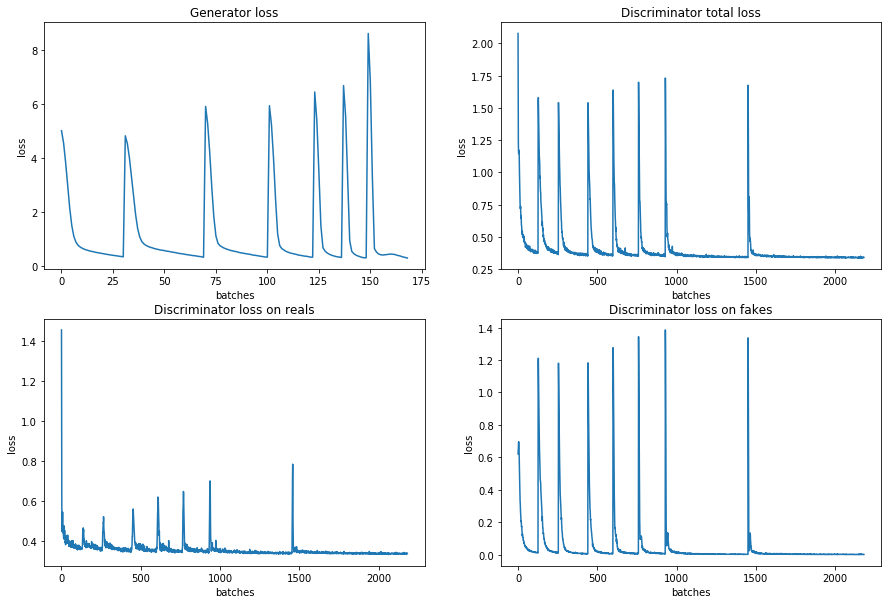

In [0]:
G_initedFC = GeneratorFC(latent_vector_length=100).to(device)

nn.init. xavier_uniform_(G_initedFC.fc1.weight)
nn.init. xavier_uniform_(G_initedFC.fc2.weight)
nn.init. xavier_uniform_(G_initedFC.fc3.weight)
nn.init. xavier_uniform_(G_initedFC.fc4.weight )

nn.init.normal_(G_initedFC.fc1.bias, 0, 0.02)
nn.init.normal_(G_initedFC.fc2.bias, 0, 0.02)
nn.init.normal_(G_initedFC.fc3.bias, 0, 0.02)
nn.init.normal_(G_initedFC.fc4.bias, 0, 0.02)

D_initedFC = DiscriminatorFC().to(device)
nn.init. xavier_uniform_(D_initedFC.fc1.weight )
nn.init. xavier_uniform_(D_initedFC.fc2.weight )
nn.init. xavier_uniform_(D_initedFC.fc3.weight )
nn.init. xavier_uniform_(D_initedFC.fc4.weight )

nn.init.normal_(D_initedFC.fc1.bias, 0, 0.02)
nn.init.normal_(D_initedFC.fc2.bias, 0, 0.02)
nn.init.normal_(D_initedFC.fc3.bias, 0, 0.02)
nn.init.normal_(D_initedFC.fc4.bias, 0, 0.02)

(imgs8, GR8, DR8) = experiment_MNIST(D_optimizer="SGD", 
                                     D_lr=0.004, 
                                     D_momentum=0.8, 
                                     G_optimizer="SGD", 
                                     G_lr=0.004, 
                                     G_momentum=0.8, 
                                     epochs=5, 
                                     D=D_initedFC, 
                                     G=G_initedFC, 
                                     train_policy_function=train_alternate_MNIST_principled_replay, 
                                     D_class=DiscriminatorFC, 
                                     G_class=GeneratorFC)

10 9


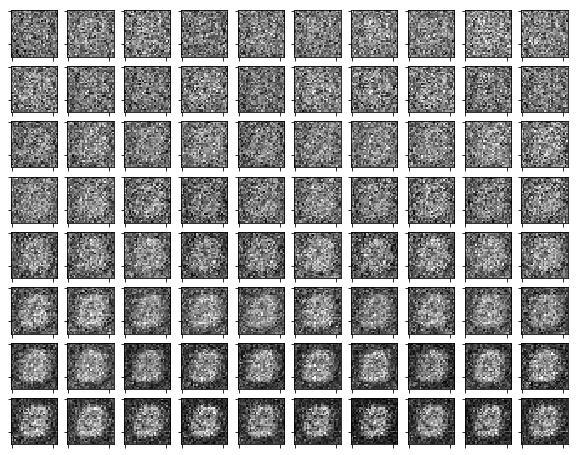

In [0]:
plot_generated_images(imgs8, num_per_row=10, skip_by=2)

Epoch #0
minibatch #0 done


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


minibatch #50 done
minibatch #100 done
minibatch #150 done
minibatch #200 done
minibatch #250 done
minibatch #300 done
minibatch #350 done
minibatch #400 done
minibatch #450 done
Epoch #1
minibatch #0 done
minibatch #50 done
minibatch #100 done
minibatch #150 done
minibatch #200 done
minibatch #250 done
minibatch #300 done
minibatch #350 done
minibatch #400 done
minibatch #450 done
Epoch #2
minibatch #0 done
minibatch #50 done
minibatch #100 done
minibatch #150 done
minibatch #200 done
minibatch #250 done
minibatch #300 done
minibatch #350 done
minibatch #400 done
minibatch #450 done
Epoch #3
minibatch #0 done
minibatch #50 done
minibatch #100 done
minibatch #150 done
minibatch #200 done
minibatch #250 done
minibatch #300 done
minibatch #350 done
minibatch #400 done
minibatch #450 done
Epoch #4
minibatch #0 done
minibatch #50 done
minibatch #100 done
minibatch #150 done
minibatch #200 done
minibatch #250 done
minibatch #300 done
minibatch #350 done
minibatch #400 done
minibatch #450 do

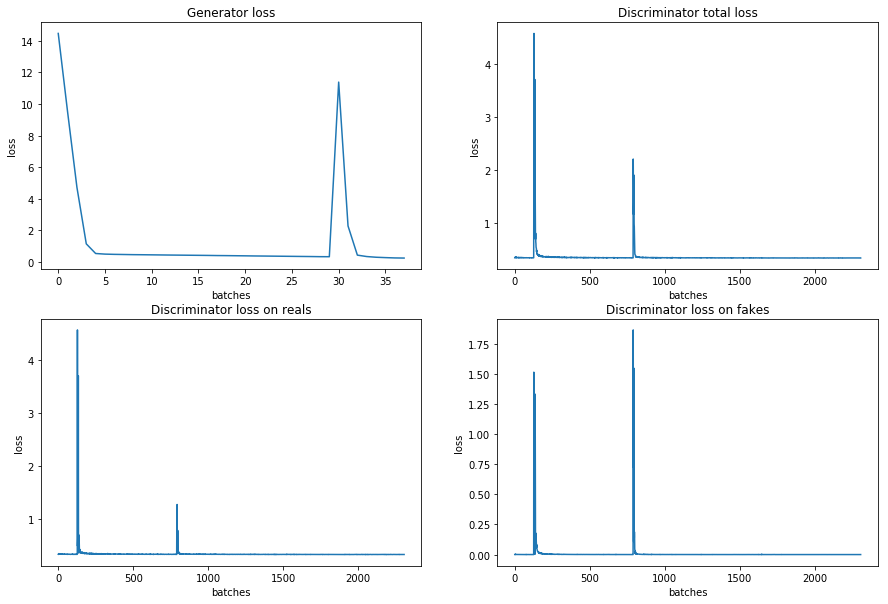

In [0]:
(imgss1, GRR1, DRR1) = experiment_MNIST(D_optimizer="Adam", 
                                     D_lr=0.0002, 
                                     D_momentum=0.8, 
                                     G_optimizer="Adam", 
                                     G_lr=0.0002, 
                                     G_momentum=0.8, 
                                     epochs=5, 
                                     D=DR8, 
                                     G=GR8, 
                                     train_policy_function=train_alternate_MNIST_principled_replay, 
                                     D_class=DiscriminatorFC, 
                                     G_class=GeneratorFC)

10 2


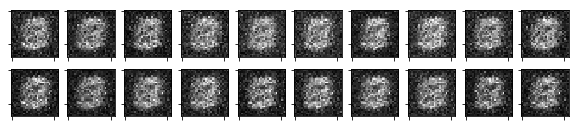

In [0]:
plot_generated_images(imgss1, num_per_row=10, skip_by=2)

Let's try normal init but with adam

Epoch #0
minibatch #0 done


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


minibatch #50 done
minibatch #100 done
minibatch #150 done
minibatch #200 done
minibatch #250 done
minibatch #300 done
minibatch #350 done
minibatch #400 done
minibatch #450 done
Epoch #1
minibatch #0 done
minibatch #50 done
minibatch #100 done
minibatch #150 done
minibatch #200 done
minibatch #250 done
minibatch #300 done
minibatch #350 done
minibatch #400 done
minibatch #450 done
Epoch #2
minibatch #0 done
minibatch #50 done
minibatch #100 done
minibatch #150 done
minibatch #200 done
minibatch #250 done
minibatch #300 done
minibatch #350 done
minibatch #400 done
minibatch #450 done
Epoch #3
minibatch #0 done
minibatch #50 done
minibatch #100 done
minibatch #150 done
minibatch #200 done
minibatch #250 done
minibatch #300 done
minibatch #350 done
minibatch #400 done
minibatch #450 done
Epoch #4
minibatch #0 done
minibatch #50 done
minibatch #100 done
minibatch #150 done
minibatch #200 done
minibatch #250 done
minibatch #300 done
minibatch #350 done
minibatch #400 done
minibatch #450 do

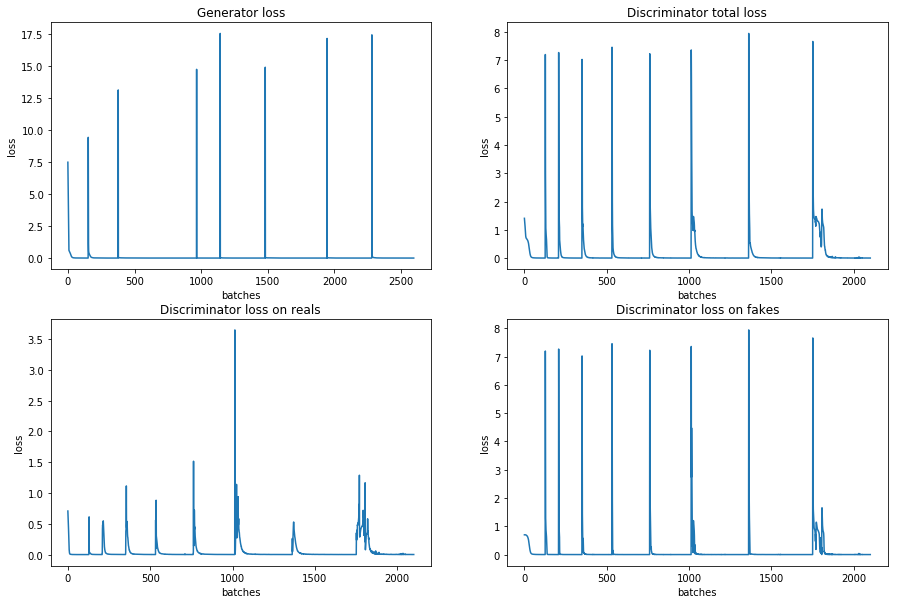

In [0]:
G_initedFC = GeneratorFC(latent_vector_length=100).to(device)

nn.init.normal_(G_initedFC.fc1.weight, 0, 0.02)
nn.init.normal_(G_initedFC.fc2.weight, 0, 0.02)
nn.init.normal_(G_initedFC.fc3.weight, 0, 0.02)
nn.init.normal_(G_initedFC.fc4.weight, 0, 0.02)

nn.init.normal_(G_initedFC.fc1.bias, 0, 0.02)
nn.init.normal_(G_initedFC.fc2.bias, 0, 0.02)
nn.init.normal_(G_initedFC.fc3.bias, 0, 0.02)
nn.init.normal_(G_initedFC.fc4.bias, 0, 0.02)

D_initedFC = DiscriminatorFC().to(device)
nn.init.normal_(D_initedFC.fc1.weight, 0, 0.02)
nn.init.normal_(D_initedFC.fc2.weight, 0, 0.02)
nn.init.normal_(D_initedFC.fc3.weight, 0, 0.02)
nn.init.normal_(D_initedFC.fc4.weight, 0, 0.02)

nn.init.normal_(D_initedFC.fc1.bias, 0, 0.02)
nn.init.normal_(D_initedFC.fc2.bias, 0, 0.02)
nn.init.normal_(D_initedFC.fc3.bias, 0, 0.02)
nn.init.normal_(D_initedFC.fc4.bias, 0, 0.02)

(imgs9, GR9, DR9) = experiment_MNIST(D_optimizer="Adam", 
                                     D_lr=0.0002, 
                                     D_momentum=0.8, 
                                     G_optimizer="Adam", 
                                     G_lr=0.0002, 
                                     G_momentum=0.8, 
                                     epochs=10, 
                                     D=D_initedFC, 
                                     G=G_initedFC, 
                                     train_policy_function=train_alternate_MNIST_principled_replay, 
                                     D_class=DiscriminatorFC, 
                                     G_class=GeneratorFC)

10 52


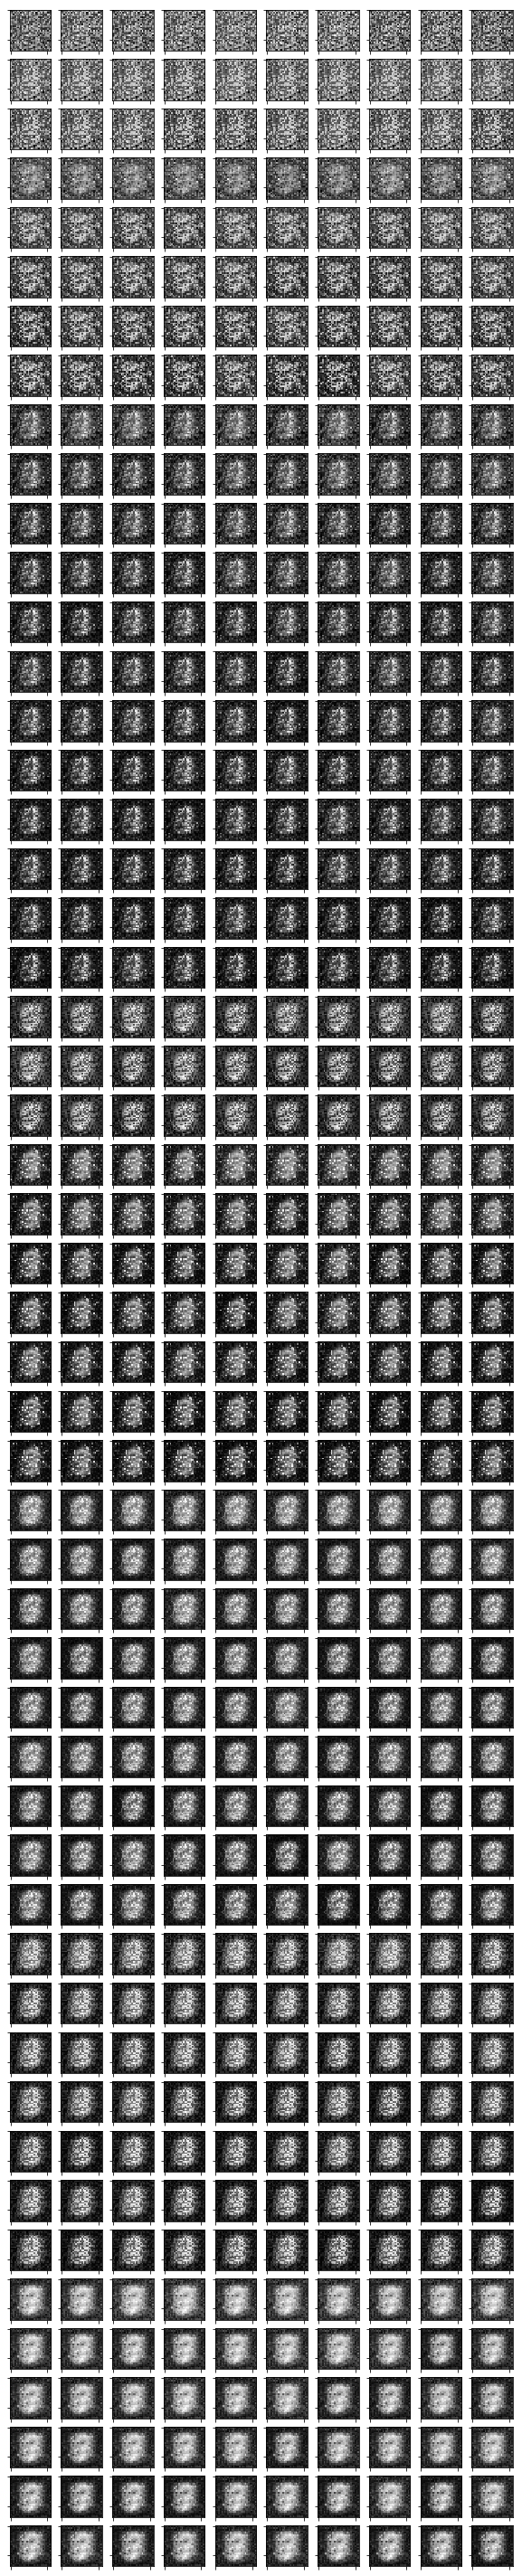

In [0]:
plot_generated_images(imgs9, num_per_row=10, skip_by=5)

In [0]:
G_inited = GeneratorAllConv(latent_vector_length=100).to(device)
nn.init.normal_(G_inited.conv_tr1.weight, 0, 0.02)
nn.init.normal_(G_inited.conv_tr2.weight, 0, 0.02)
nn.init.normal_(G_inited.conv_tr3.weight, 0, 0.02)
nn.init.normal_(G_inited.conv_tr4.weight, 0, 0.02)

D_inited = DiscriminatorAllConv().to(device)
nn.init.normal_(D_inited.conv1.weight, 0, 0.02)
nn.init.normal_(D_inited.conv2.weight, 0, 0.02)
nn.init.normal_(D_inited.conv3.weight, 0, 0.02)
nn.init.normal_(D_inited.conv4.weight, 0, 0.02)

(imgs7, GR7, DR7) = experiment_MNIST(D_optimizer="SGD", 
                                     D_lr=0.005, 
                                     D_momentum=0.8, 
                                     G_optimizer="SGD", 
                                     G_lr=0.005, 
                                     G_momentum=0.8, 
                                     epochs=5, 
                                     D=D_inited, 
                                     G=G_inited, 
                                     train_policy_function=train_alternate_MNIST_principled_replay, 
                                     D_class=DiscriminatorAllConv, 
                                     G_class=GeneratorAllConv)

In [0]:
plot_generated_images(imgs7[:], num_per_row=2, skip_by=5)

Let's try that but with biases

Epoch #0
minibatch #0 done


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


minibatch #50 done
minibatch #100 done
minibatch #150 done
minibatch #200 done
minibatch #250 done
minibatch #300 done
minibatch #350 done
minibatch #400 done
minibatch #450 done
Epoch #1
minibatch #0 done
minibatch #50 done
minibatch #100 done
minibatch #150 done
minibatch #200 done
minibatch #250 done
minibatch #300 done
minibatch #350 done
minibatch #400 done
minibatch #450 done
Epoch #2
minibatch #0 done
minibatch #50 done
minibatch #100 done
minibatch #150 done
minibatch #200 done
minibatch #250 done
minibatch #300 done
minibatch #350 done
minibatch #400 done
minibatch #450 done
Epoch #3
minibatch #0 done
minibatch #50 done
minibatch #100 done
minibatch #150 done
minibatch #200 done
minibatch #250 done
minibatch #300 done
minibatch #350 done
minibatch #400 done
minibatch #450 done
Epoch #4
minibatch #0 done
minibatch #50 done
minibatch #100 done
minibatch #150 done
minibatch #200 done
minibatch #250 done
minibatch #300 done
minibatch #350 done
minibatch #400 done
minibatch #450 do

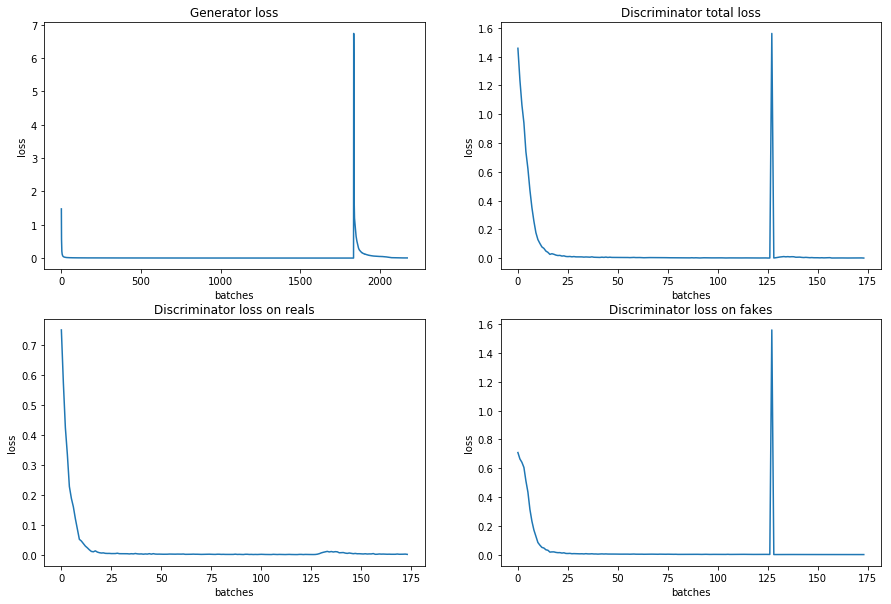

In [0]:
G_inited = GeneratorAllConv(latent_vector_length=100).to(device)
nn.init.normal_(G_inited.conv_tr1.weight, 0, 0.02)
nn.init.normal_(G_inited.conv_tr2.weight, 0, 0.02)
nn.init.normal_(G_inited.conv_tr3.weight, 0, 0.02)
nn.init.normal_(G_inited.conv_tr4.weight, 0, 0.02)

nn.init.normal_(G_inited.conv_tr1.bias, 0, 0.02)
nn.init.normal_(G_inited.conv_tr2.bias, 0, 0.02)
nn.init.normal_(G_inited.conv_tr3.bias, 0, 0.02)
nn.init.normal_(G_inited.conv_tr4.bias, 0, 0.02)

D_inited = DiscriminatorAllConv().to(device)
nn.init.normal_(D_inited.conv1.weight, 0, 0.02)
nn.init.normal_(D_inited.conv2.weight, 0, 0.02)
nn.init.normal_(D_inited.conv3.weight, 0, 0.02)
nn.init.normal_(D_inited.conv4.weight, 0, 0.02)

nn.init.normal_(D_inited.conv1.bias, 0, 0.02)
nn.init.normal_(D_inited.conv2.bias, 0, 0.02)
nn.init.normal_(D_inited.conv3.bias, 0, 0.02)
nn.init.normal_(D_inited.conv4.bias, 0, 0.02)

(imgs7, GR7, DR7) = experiment_MNIST(D_optimizer="SGD", 
                                     D_lr=0.005, 
                                     D_momentum=0.8, 
                                     G_optimizer="SGD", 
                                     G_lr=0.005, 
                                     G_momentum=0.8, 
                                     epochs=5, 
                                     D=D_inited, 
                                     G=G_inited, 
                                     train_policy_function=train_alternate_MNIST_principled_replay, 
                                     D_class=DiscriminatorAllConv, 
                                     G_class=GeneratorAllConv)

Seems like it has latched onto something. 
Changing the training decision condition from d_loss > g_loss / 2 to d_loss > g_loss

In [0]:
G_inited = GeneratorAllConv(latent_vector_length=100).to(device)
nn.init.normal_(G_inited.conv_tr1.weight, 0, 0.02)
nn.init.normal_(G_inited.conv_tr2.weight, 0, 0.02)
nn.init.normal_(G_inited.conv_tr3.weight, 0, 0.02)
nn.init.normal_(G_inited.conv_tr4.weight, 0, 0.02)

nn.init.normal_(G_inited.conv_tr1.bias, 0, 0.02)
nn.init.normal_(G_inited.conv_tr2.bias, 0, 0.02)
nn.init.normal_(G_inited.conv_tr3.bias, 0, 0.02)
nn.init.normal_(G_inited.conv_tr4.bias, 0, 0.02)

D_inited = DiscriminatorAllConv().to(device)
nn.init.normal_(D_inited.conv1.weight, 0, 0.02)
nn.init.normal_(D_inited.conv2.weight, 0, 0.02)
nn.init.normal_(D_inited.conv3.weight, 0, 0.02)
nn.init.normal_(D_inited.conv4.weight, 0, 0.02)

nn.init.normal_(D_inited.conv1.bias, 0, 0.02)
nn.init.normal_(D_inited.conv2.bias, 0, 0.02)
nn.init.normal_(D_inited.conv3.bias, 0, 0.02)
nn.init.normal_(D_inited.conv4.bias, 0, 0.02)

(imgs10, GR10, DR10) = experiment_MNIST(D_optimizer="SGD", 
                                     D_lr=0.005, 
                                     D_momentum=0.9, 
                                     G_optimizer="Adam", 
                                     G_lr=0.0004, 
                                     G_momentum=0.8, 
                                     epochs=30, 
                                     D=D_inited, 
                                     G=G_inited, 
                                     train_policy_function=train_alternate_MNIST_principled_replay, 
                                     D_class=DiscriminatorAllConv, 
                                     G_class=GeneratorAllConv)

Epoch #0
minibatch #0 done


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


minibatch #50 done
minibatch #100 done
minibatch #150 done
minibatch #200 done
minibatch #250 done
minibatch #300 done
minibatch #350 done
minibatch #400 done
minibatch #450 done
Epoch #1
minibatch #0 done
minibatch #50 done
minibatch #100 done
minibatch #150 done
minibatch #200 done
minibatch #250 done
minibatch #300 done
minibatch #350 done
minibatch #400 done
minibatch #450 done
Epoch #2
minibatch #0 done
minibatch #50 done


KeyboardInterrupt: ignored

In [0]:
plot_generated_images(imgs10, num_per_row=4, skip_by=4)

Let's try upsampling with convolution instead of transpose convolution

In [0]:
# def GeneratorUpSample(nn.Module):
#     def __init__(self, latent_vector_length=25):
#         super().__init__()
#         self.latent_vector_length = latent_vector_length
#         self.conv1 = 

Let's try smooth labels. for real examples, train D to get them to 0.9 instead of 1.(Why?)

Let's try a long one. 200 epochs, Adam both, lr=0.0002. But first a little scouting run with 10 epochs

In [0]:
def params_init(module):
    if isinstance(module, nn.Linear):
        nn.init.normal_(module.weight, 0, 0.02)
        nn.init.normal_(module.bias, 0, 0.02)
     
    if isinstance(module, nn.Conv2d):
        nn.init.kaiming_normal_(module.weight)

In [52]:
G_initedFC = GeneratorAllConv(latent_vector_length=100).to(device)

G_initedFC.apply(params_init)

D_initedFC = DiscriminatorAllConv().to(device)

D_initedFC.apply(params_init)

DiscriminatorAllConv(
  (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
  (conv4): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1))
  (conv_bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leakyrelu): LeakyReLU(negative_slope=0.1)
)

In [46]:
G_initedFC = GeneratorFC(latent_vector_length=100).to(device)

G_initedFC.apply(params_init)

D_initedFC = DiscriminatorFC().to(device)

D_initedFC.apply(params_init)

DiscriminatorFC(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
  (leakyrelu): LeakyReLU(negative_slope=0.2)
)

Epoch #0
iteration#0 done


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


iteration#50 done
iteration#100 done
iteration#150 done
iteration#200 done
iteration#250 done
iteration#300 done
iteration#350 done
iteration#400 done
iteration#450 done
Epoch #1
iteration#0 done
iteration#50 done
iteration#100 done
iteration#150 done
iteration#200 done
iteration#250 done
iteration#300 done
iteration#350 done
iteration#400 done
iteration#450 done
Epoch #2
iteration#0 done
iteration#50 done
iteration#100 done
iteration#150 done
iteration#200 done
iteration#250 done
iteration#300 done
iteration#350 done
iteration#400 done
iteration#450 done
Epoch #3
iteration#0 done
iteration#50 done
iteration#100 done
iteration#150 done
iteration#200 done
iteration#250 done
iteration#300 done
iteration#350 done
iteration#400 done
iteration#450 done
Epoch #4
iteration#0 done
iteration#50 done
iteration#100 done
iteration#150 done
iteration#200 done
iteration#250 done
iteration#300 done
iteration#350 done
iteration#400 done
iteration#450 done
Epoch #5
iteration#0 done
iteration#50 done
it

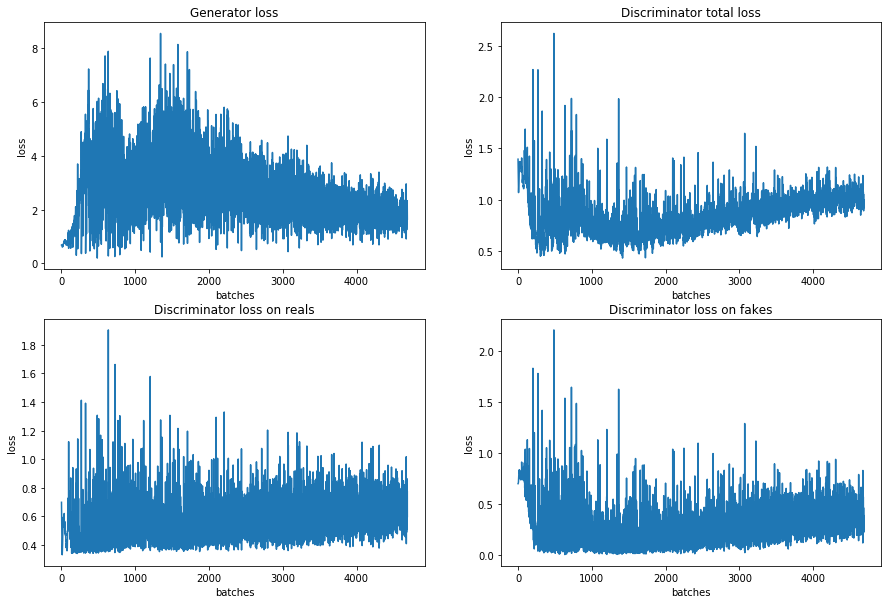

In [55]:
G_initedFC = GeneratorFC(latent_vector_length=100).to(device)
G_initedFC.apply(params_init)

D_initedFC = DiscriminatorFC().to(device)
D_initedFC.apply(params_init)

(imgs9, GR9, DR9) = experiment_MNIST(D_optimizer="Adam", 
                                     D_lr=0.0002, 
                                     D_momentum=None, 
                                     G_optimizer="Adam", 
                                     G_lr=0.0002, 
                                     G_momentum=None, 
                                     epochs=10, 
                                     D=D_initedFC, 
                                     G=G_initedFC, 
                                     train_policy_function=train_alternate_MNIST, 
                                     D_class=DiscriminatorFC, 
                                     G_class=GeneratorFC)

In [0]:
??GR9.apply

10 51


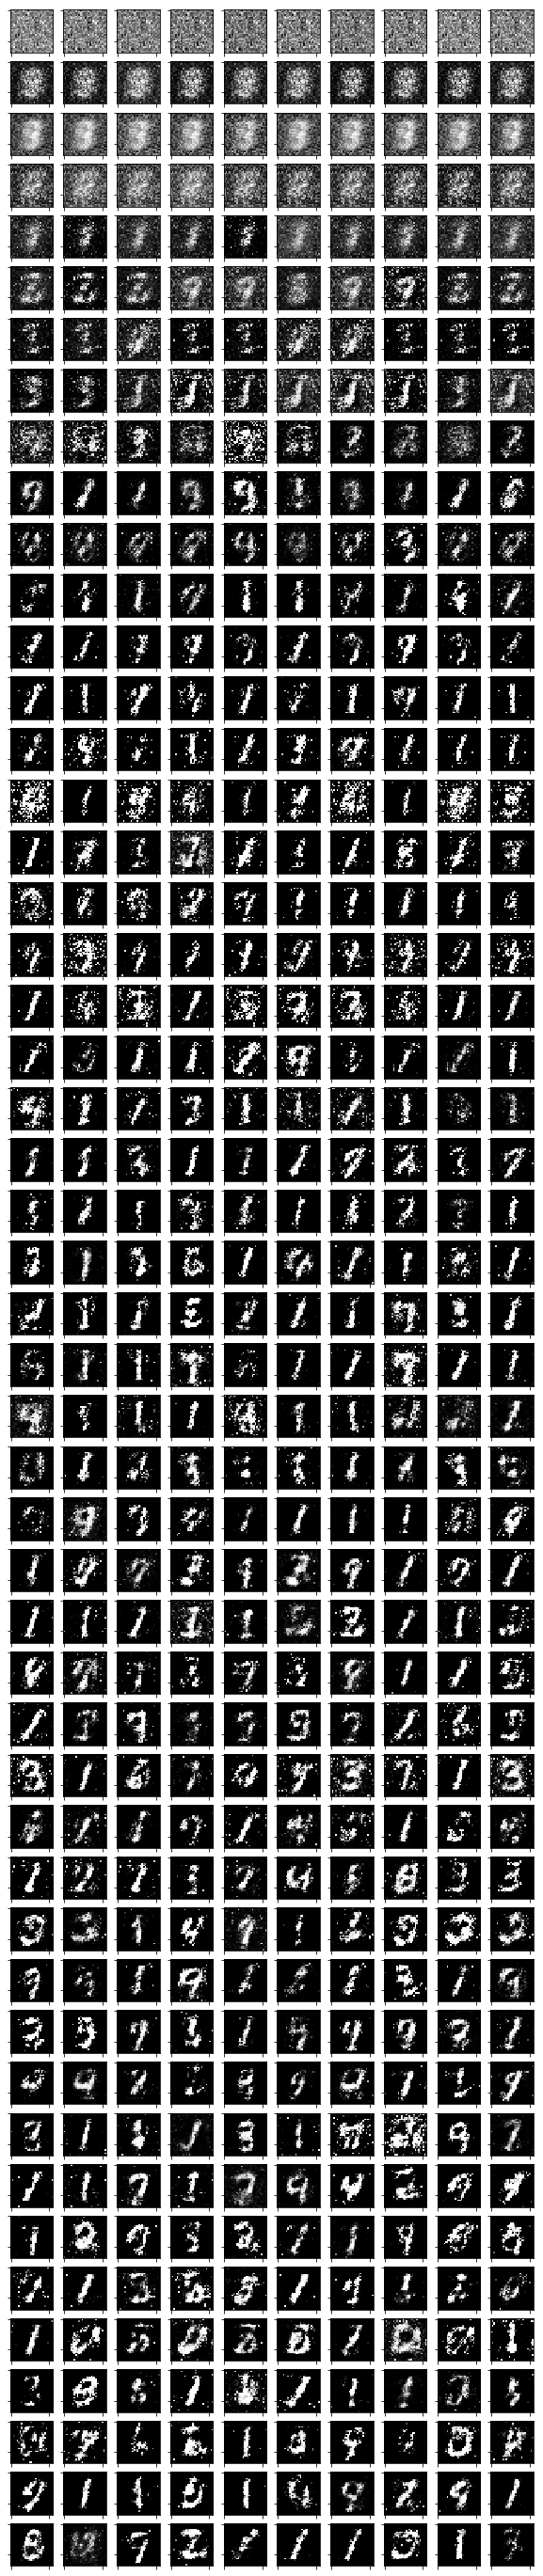

In [57]:
plot_generated_images(imgs9, num_per_row=10, skip_by=2)

Went back to the simple alternate training version and it seemed to have gotten kinda good in only 5 epochs: variation in the generated images, less cloudiness...WAT?


Epoch #0
iteration#0 done


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


iteration#50 done
iteration#100 done
iteration#150 done
iteration#200 done
iteration#250 done
iteration#300 done
iteration#350 done
iteration#400 done
iteration#450 done
Epoch #1
iteration#0 done
iteration#50 done
iteration#100 done
iteration#150 done
iteration#200 done
iteration#250 done
iteration#300 done
iteration#350 done
iteration#400 done
iteration#450 done
Epoch #2
iteration#0 done
iteration#50 done
iteration#100 done
iteration#150 done
iteration#200 done
iteration#250 done
iteration#300 done
iteration#350 done
iteration#400 done
iteration#450 done
Epoch #3
iteration#0 done
iteration#50 done
iteration#100 done
iteration#150 done
iteration#200 done
iteration#250 done
iteration#300 done
iteration#350 done
iteration#400 done
iteration#450 done
Epoch #4
iteration#0 done
iteration#50 done
iteration#100 done
iteration#150 done
iteration#200 done
iteration#250 done
iteration#300 done
iteration#350 done
iteration#400 done
iteration#450 done
Epoch #5
iteration#0 done
iteration#50 done
it

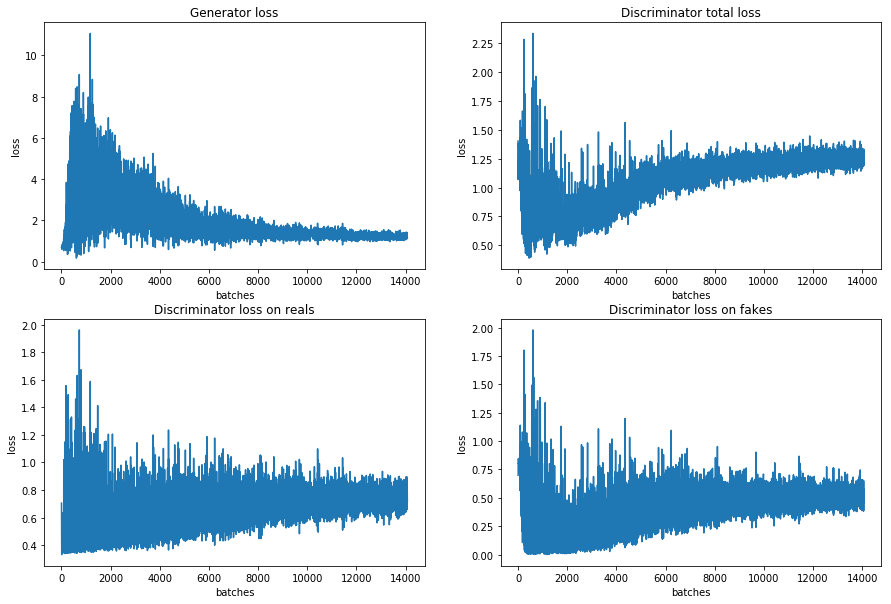

In [0]:
G_initedFC = GeneratorFC(latent_vector_length=100).to(device)

nn.init.normal_(G_initedFC.fc1.weight, 0, 0.02)
nn.init.normal_(G_initedFC.fc2.weight, 0, 0.02)
nn.init.normal_(G_initedFC.fc3.weight, 0, 0.02)
nn.init.normal_(G_initedFC.fc4.weight, 0, 0.02)

nn.init.normal_(G_initedFC.fc1.bias, 0, 0.02)
nn.init.normal_(G_initedFC.fc2.bias, 0, 0.02)
nn.init.normal_(G_initedFC.fc3.bias, 0, 0.02)
nn.init.normal_(G_initedFC.fc4.bias, 0, 0.02)

D_initedFC = DiscriminatorFC().to(device)
nn.init.normal_(D_initedFC.fc1.weight, 0, 0.02)
nn.init.normal_(D_initedFC.fc2.weight, 0, 0.02)
nn.init.normal_(D_initedFC.fc3.weight, 0, 0.02)
nn.init.normal_(D_initedFC.fc4.weight, 0, 0.02)

nn.init.normal_(D_initedFC.fc1.bias, 0, 0.02)
nn.init.normal_(D_initedFC.fc2.bias, 0, 0.02)
nn.init.normal_(D_initedFC.fc3.bias, 0, 0.02)
nn.init.normal_(D_initedFC.fc4.bias, 0, 0.02)

(imgsDAM, GRDAM, DRDAM) = experiment_MNIST(D_optimizer="Adam", 
                                     D_lr=0.0002, 
                                     D_momentum=0.8, 
                                     G_optimizer="Adam", 
                                     G_lr=0.0002, 
                                     G_momentum=0.8, 
                                     epochs=30, 
                                     D=D_initedFC, 
                                     G=G_initedFC, 
                                     train_policy_function=train_alternate_MNIST, 
                                     D_class=DiscriminatorFC, 
                                     G_class=GeneratorFC)

10 76


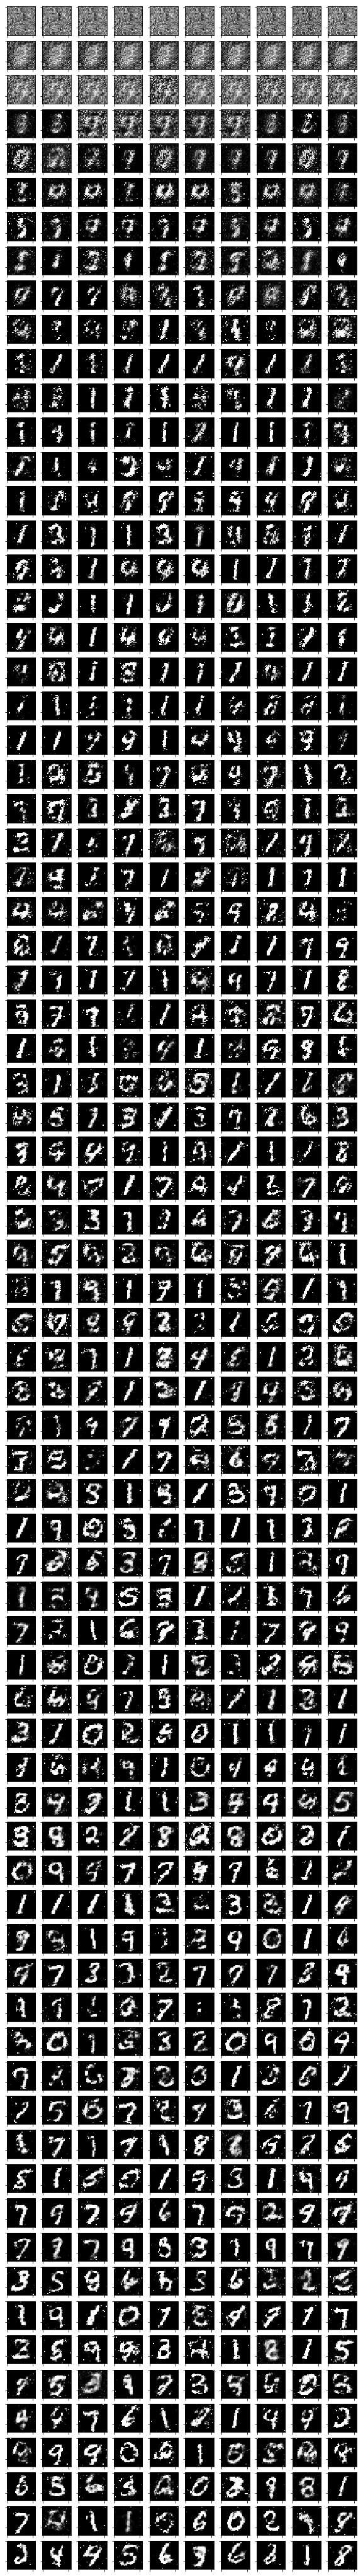

In [0]:
plot_generated_images(imgsDAM, num_per_row=10, skip_by=4)

Pretty good! But what changed from the previous models to this one?

Variables to check: 1) xavier/normal init vs default 2) soft target for reals 3) Adam with specifically lr = 0.0002 vs SGD vs Adam with different lr 4) alternate vs conditional training 5) Replay memory with the working model

Side note: The G loss went upto about 10 in the beginning many times, but the upper bound slowly decreased. Why did I assume that a loss > ~1 is BAD?

In [0]:
def interpolate_image(vec1, vec2, num_images, G):
    plt.rcParams["figure.figsize"] = [num_images, 1]
    diff = vec2 - vec1
    
    images = []
    
    plt.subplot(1, num_images, 1)
    images.append(G(vec1.to(device)).detach().cpu().view(28, 28))
    plt.imshow(images[-1], cmap="gray")
    
    for i in range(1, num_images-1):
        delta = diff * (i / (num_images-1))
        images.append(
            G((vec1 + delta).to(device)).detach().cpu().view(28, 28)
        )
        plt.subplot(1, num_images, 1 + i)
        plt.imshow(images[-1], cmap="gray")
    
    images.append(G(vec2.to(device)).detach().cpu().view(28, 28))
    plt.subplot(1, num_images, num_images)
    plt.imshow(images[-1], cmap="gray")
    

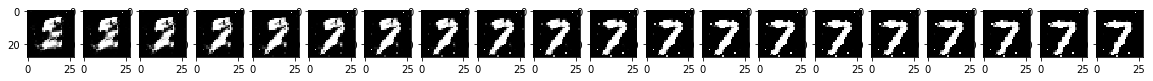

In [18]:
interpolate_image(torch.randn(100), torch.randn(100), 20, GR9)

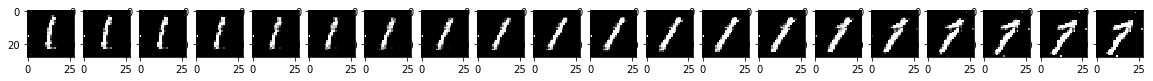

In [24]:
interpolate_image(torch.randn(100), torch.randn(100), 20, GR9)

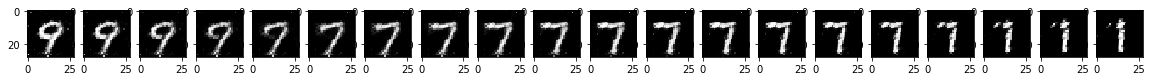

In [20]:
interpolate_image(torch.randn(100), torch.randn(100), 20, GR9)

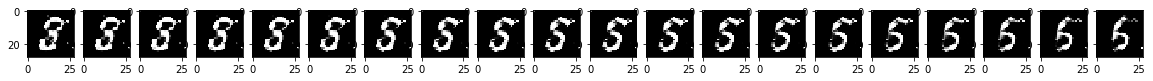

In [27]:
interpolate_image(torch.randn(100), torch.randn(100), 20, GR9)

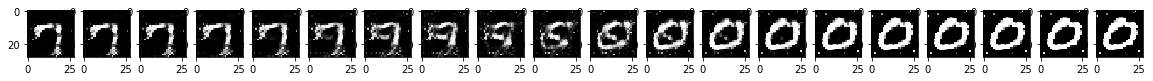

In [22]:
interpolate_image(torch.randn(100), torch.randn(100), 20, GR9)

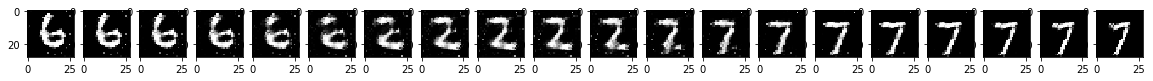

In [28]:
interpolate_image(torch.randn(100), torch.randn(100), 20, GR9)

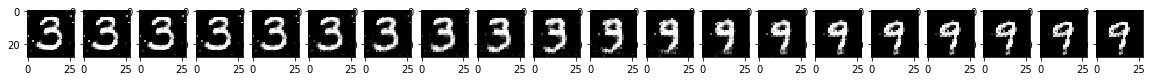

In [38]:
interpolate_image(torch.randn(100), torch.randn(100), 20, GR9)

2 things to test first: (FC, Adam, lrD=lrG=0.0002, epochs=100), and (Conv, Adam, lrD=lrG=0.0002, epochs=100)

Epoch #0
iteration#0 done


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


iteration#50 done
iteration#100 done
iteration#150 done
iteration#200 done
iteration#250 done
iteration#300 done
iteration#350 done
iteration#400 done
iteration#450 done
Epoch #1
iteration#0 done
iteration#50 done
iteration#100 done
iteration#150 done
iteration#200 done
iteration#250 done
iteration#300 done
iteration#350 done
iteration#400 done
iteration#450 done
Epoch #2
iteration#0 done
iteration#50 done
iteration#100 done
iteration#150 done
iteration#200 done
iteration#250 done
iteration#300 done
iteration#350 done
iteration#400 done
iteration#450 done
Epoch #3
iteration#0 done
iteration#50 done
iteration#100 done
iteration#150 done
iteration#200 done
iteration#250 done
iteration#300 done
iteration#350 done
iteration#400 done
iteration#450 done
Epoch #4
iteration#0 done
iteration#50 done
iteration#100 done
iteration#150 done
iteration#200 done
iteration#250 done
iteration#300 done
iteration#350 done
iteration#400 done
iteration#450 done
Epoch #5
iteration#0 done
iteration#50 done
it

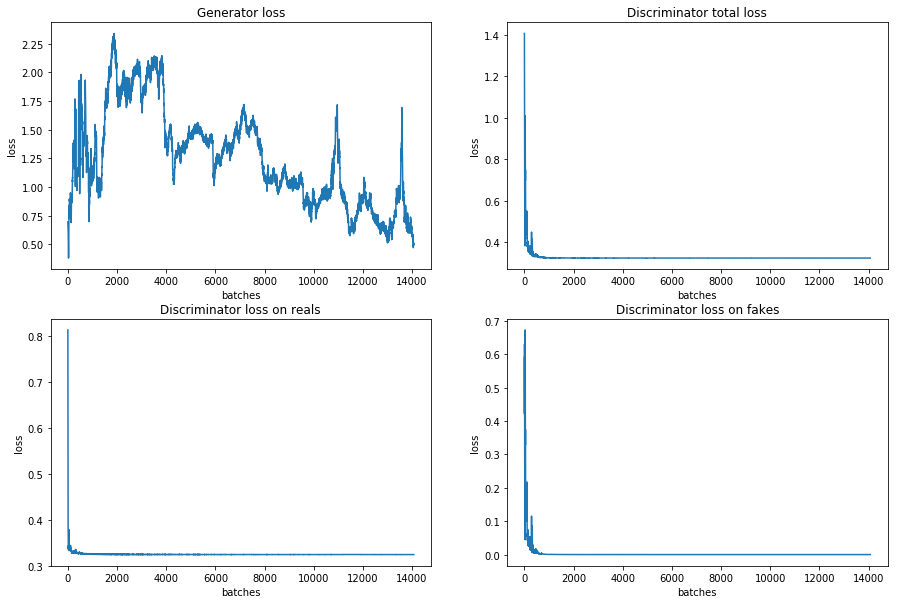

In [0]:
G_inited = GeneratorAllConv(latent_vector_length=100).to(device)
nn.init.normal_(G_inited.conv_tr1.weight, 0, 0.02)
nn.init.normal_(G_inited.conv_tr2.weight, 0, 0.02)
nn.init.normal_(G_inited.conv_tr3.weight, 0, 0.02)
nn.init.normal_(G_inited.conv_tr4.weight, 0, 0.02)

nn.init.normal_(G_inited.conv_tr1.bias, 0, 0.02)
nn.init.normal_(G_inited.conv_tr2.bias, 0, 0.02)
nn.init.normal_(G_inited.conv_tr3.bias, 0, 0.02)
nn.init.normal_(G_inited.conv_tr4.bias, 0, 0.02)

D_inited = DiscriminatorAllConv().to(device)
nn.init.normal_(D_inited.conv1.weight, 0, 0.02)
nn.init.normal_(D_inited.conv2.weight, 0, 0.02)
nn.init.normal_(D_inited.conv3.weight, 0, 0.02)
nn.init.normal_(D_inited.conv4.weight, 0, 0.02)

nn.init.normal_(D_inited.conv1.bias, 0, 0.02)
nn.init.normal_(D_inited.conv2.bias, 0, 0.02)
nn.init.normal_(D_inited.conv3.bias, 0, 0.02)
nn.init.normal_(D_inited.conv4.bias, 0, 0.02)

(imgsC1, GC1, DC1) = experiment_MNIST(D_optimizer="Adam", 
                                     D_lr=0.0002, 
                                     D_momentum=0.8, 
                                     G_optimizer="Adam", 
                                     G_lr=0.0002, 
                                     G_momentum=0.8, 
                                     epochs=30, 
                                     D=D_inited, 
                                     G=G_inited, 
                                     train_policy_function=train_alternate_MNIST, 
                                     D_class=DiscriminatorAllConv, 
                                     G_class=GeneratorAllConv)

10 151


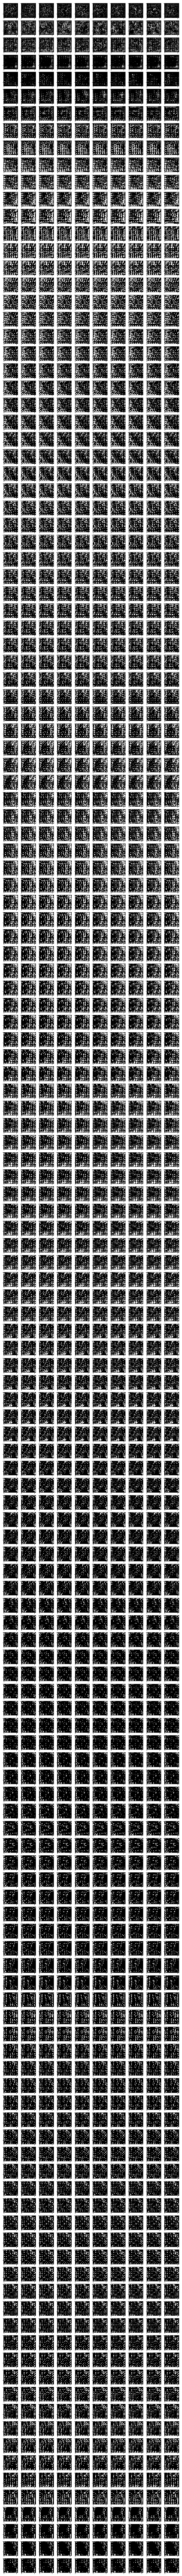

In [0]:
plot_generated_images(imgsC1, num_per_row=10, skip_by=2)